# Домашнее задание 5

Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации - выбить auc выше 0.95
2. Предобучаем word2vec и его эмбединга инициализируем сетку, как влияет на качество?

Инсталлируем библиотеки

In [1]:
!pip install stop_words

In [2]:
!pip install pymorphy2

Подключим библиотеки

In [3]:
import pandas as pd
import numpy as np

import nltk

Скачаем данные

In [4]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Установим гиперпараметры

In [5]:
max_words = 2000
max_len = 50

epochs = 200
batch_size = 512

Считаем данные с диска

In [6]:
data = pd.read_excel("отзывы за лето.xls", )

In [7]:
data.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [8]:
import tensorflow as tf

In [9]:
if tf.__version__.startswith("1."):
    val_acc_name = "val_acc"
    acc_name = "acc"
else:
    val_acc_name = "val_accuracy"
    acc_name = "accuracy"

In [10]:
from stop_words import get_stop_words
from string import punctuation
from pymorphy2 import MorphAnalyzer

In [11]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

In [12]:
def preprocess_text(txt):
    txt = str(txt)
    txt = re.sub(r'( )+', " ", re.sub(r'[^\w\s]', " ", txt)).strip()
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    txt = " ".join(txt)
    txt = re.sub("\sне", "не", txt)
    return txt

In [13]:
import re

In [14]:
text111 = data.iloc[12]["Content"]
print(text111)
preprocessed_text111 = preprocess_text(text111)
print(type(preprocessed_text111))
print(preprocessed_text111)

Не стартует без доступа к gps, sms, звонкам и адресной книге. Филиал фсб одним словом
<class 'str'>
стартовать доступ gps sms звонок адресный книга филиал фсб один слово


In [15]:
data.Rating.unique()

array([5, 4, 2, 3, 1])

In [16]:
data.Rating = data.Rating - 1
data.head()

,Rating,Content,Date
0,4,It just works!,2017-08-14
1,3,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,4,Отлично все,2017-08-14
3,4,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,4,"Очень удобно, работает быстро.",2017-08-14


In [17]:
data.Rating.unique()

array([4, 3, 1, 2, 0])

In [18]:
vfunc = np.vectorize(preprocess_text)

In [19]:
%%time
data["text"] = vfunc(data.Content)
data.head()

CPU times: user 15.8 s, sys: 345 ms, total: 16.1 s
Wall time: 16.1 s


In [20]:
train_corpus = " ".join(data["text"])
train_corpus = train_corpus.lower()

In [21]:
from nltk.tokenize import word_tokenize

In [22]:
tokens = word_tokenize(train_corpus)

In [23]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [24]:
from nltk.probability import FreqDist

In [25]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [26]:
len(tokens_filtered_top)

1999

In [27]:
tokens_filtered_top[:20]

['приложение',
 'удобно',
 'работать',
 'удобный',
 'отлично',
 'нравиться',
 'хороший',
 'телефон',
 'отличный',
 'супер',
 'обновление',
 'быстро',
 'пароль',
 'банк',
 'пользоваться',
 'мочь',
 'антивирус',
 'сбербанк',
 'раз',
 'устраивать']

In [28]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [29]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [30]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in data["text"]], dtype=np.int32)

In [31]:
x_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,   97,    1,  125,  175,  112,   68, 1348,
        397,    8,   34,   15,  563,  441], dtype=int32)

In [32]:
data["Rating"].unique()

array([4, 3, 1, 2, 0])

In [33]:
num_classes = len(data["Rating"].unique())
num_classes

5

In [34]:
from tensorflow import keras

In [35]:
y_train = keras.utils.to_categorical(data["Rating"], num_classes)

In [36]:
keras.backend.clear_session()

embed_vec_len = 50

X_input = tf.keras.layers.Input(shape=(max_len,), name="X")
Embed_ = tf.keras.layers.Embedding(input_dim=max_words, output_dim=embed_vec_len, name="Embed_")(X_input)
Conv1_ = tf.keras.layers.Conv1D(filters=embed_vec_len*10, kernel_size=5, activation="relu", name="Conv1_")(Embed_)
GlobMaxPool1_ = tf.keras.layers.GlobalMaxPool1D(name="GlobMaxPool1")(Conv1_)
Drop1_ = tf.keras.layers.Dropout(0.6)(GlobMaxPool1_)
Dense1_ = tf.keras.layers.Dense(32, activation="relu", name="Dense1_")(Drop1_)
Drop2_ = tf.keras.layers.Dropout(0.6)(Dense1_)
Dense2_ = tf.keras.layers.Dense(32, activation="relu", name="Dense2_")(Drop2_)
Drop3_ = tf.keras.layers.Dropout(0.6)(Dense2_)
Dense3_ = tf.keras.layers.Dense(32, activation="relu", name="Dense3_")(Drop3_)
Drop4_ = tf.keras.layers.Dropout(0.6)(Dense3_)
Dense4_ = tf.keras.layers.Dense(32, activation="relu", name="Dense4_")(Drop4_)
Drop5_ = tf.keras.layers.Dropout(0.75)(Dense4_)
y_output = tf.keras.layers.Dense(num_classes, activation="softmax", name="y")(Drop5_)

model = tf.keras.models.Model(inputs=[X_input], outputs=[y_output], name="my_model")
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               [(None, 50)]              0         
_________________________________________________________________
Embed_ (Embedding)           (None, 50, 50)            100000    
_________________________________________________________________
Conv1_ (Conv1D)              (None, 46, 500)           125500    
_________________________________________________________________
GlobMaxPool1 (GlobalMaxPooli (None, 500)               0         
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
Dense1_ (Dense)              (None, 32)                16032     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0  

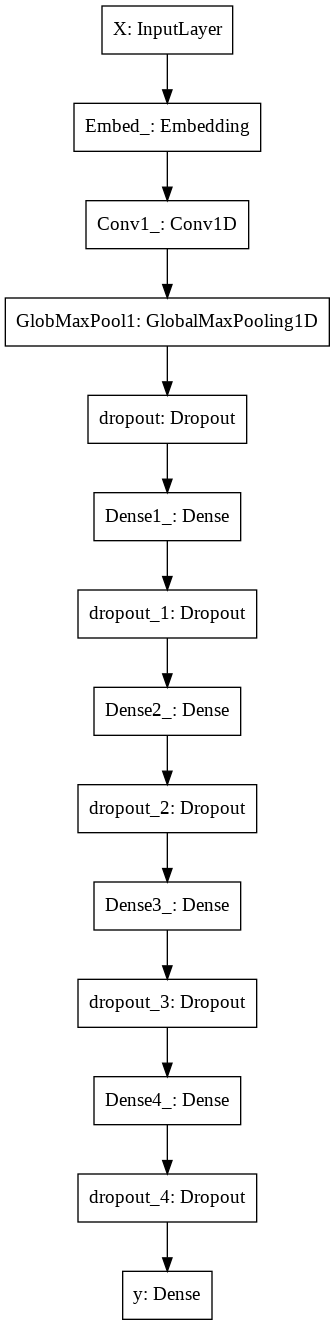

In [38]:
tf.keras.utils.plot_model(model)

In [39]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    )

Epoch 1/200
37/37 [==============================] - 1s 31ms/step - loss: 1.4334 - accuracy: 0.4362 - val_loss: 1.2422 - val_accuracy: 0.5954
Epoch 2/200
37/37 [==============================] - 1s 17ms/step - loss: 1.1122 - accuracy: 0.6529 - val_loss: 0.9906 - val_accuracy: 0.5954
Epoch 3/200
37/37 [==============================] - 1s 17ms/step - loss: 0.9394 - accuracy: 0.6960 - val_loss: 0.9447 - val_accuracy: 0.5954
Epoch 4/200
37/37 [==============================] - 1s 17ms/step - loss: 0.8621 - accuracy: 0.7067 - val_loss: 0.9273 - val_accuracy: 0.5954
Epoch 5/200
37/37 [==============================] - 1s 17ms/step - loss: 0.8208 - accuracy: 0.7119 - val_loss: 0.9127 - val_accuracy: 0.5954
Epoch 6/200
37/37 [==============================] - 1s 17ms/step - loss: 0.7792 - accuracy: 0.7151 - val_loss: 0.9094 - val_accuracy: 0.5954
Epoch 7/200
37/37 [==============================] - 1s 17ms/step - loss: 0.7600 - accuracy: 0.7154 - val_loss: 0.9167 - val_accuracy: 0.5954
Epoch 

In [40]:
import matplotlib.pyplot as plt

In [41]:
def plot_history(history):    
    fig, ax = plt.subplots(1,2, figsize=(16,4))

    ax[0].plot(history.history['loss'], label='train loss')
    ax[0].plot(history.history['val_loss'], label='validation loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(history.history['accuracy'], label='train accuracy')
    ax[1].plot(history.history['val_accuracy'], label='validation accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()

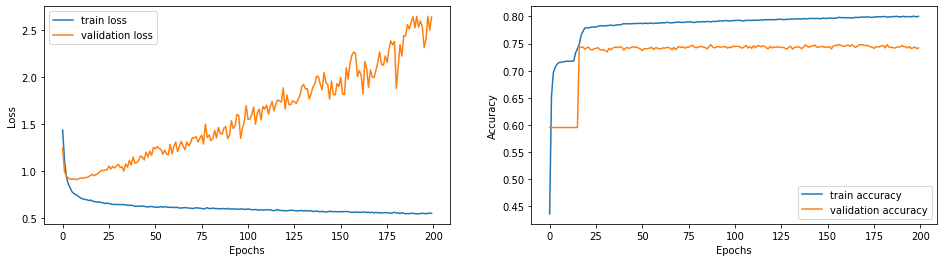

In [42]:
plot_history(history)

**Тренировка Word2Vec и использование полученных весов для инициализации эмбедингов векторов**

In [43]:
sentences_list_of_lists = [[sentence] for sentence in data.text.tolist()]
sentences_list_of_lists[:10]

[['it just works'],
 ['целое удобноной приложение минус хотеть большой доступ персональный данные телефон приходиться пользоваться ограниченный режим'],
 ['отлично'],
 ['зависать 1 работа антивирус ранее пользоваться нормально'],
 ['удобно работать быстро'],
 ['удобно норма'],
 ['удобный приложение'],
 ['устраивать'],
 ['работать чётко отличие банкомат вечно зависать тупить'],
 ['']]

In [44]:
from gensim.models import Word2Vec

In [45]:
w2v_model = Word2Vec(sentences=sentences_list_of_lists, 
                     size=embed_vec_len, 
                     window=10, 
                     min_count=2)

In [46]:
buffer = np.random.random((max_words,embed_vec_len))
buffer

array([[0.35893124, 0.39603251, 0.63523675, ..., 0.90896219, 0.98624111,
        0.80311057],
       [0.72915444, 0.85632373, 0.25050127, ..., 0.50637272, 0.55696655,
        0.86076586],
       [0.65613371, 0.53089032, 0.84580524, ..., 0.80586522, 0.40162423,
        0.68379636],
       ...,
       [0.18817882, 0.43741245, 0.25890143, ..., 0.79321075, 0.04877456,
        0.58773397],
       [0.93002022, 0.27983428, 0.58537928, ..., 0.95611425, 0.62061254,
        0.66196344],
       [0.67752301, 0.49472648, 0.34745897, ..., 0.13631948, 0.05441026,
        0.63283249]])

In [47]:
for word in vocabulary:
    if word in w2v_model.wv:
        buffer[vocabulary[word]] = w2v_model.wv[word]

In [48]:
w2v_model.wv.vocab.keys()

dict_keys(['отлично', 'удобный приложение', 'устраивать', '', 'около', 'удобно', 'удобный штука', 'отличный приложение', 'удобно практично', 'удобно быстро', 'хороший приложение', 'полезный', 'супер', 'молодец', 'круто', 'хорошечный', 'норма', 'понятно', 'приложение супер', 'загружаться', 'удобно сбербанк', 'приятно работать', 'клёво', 'лагаета', 'нравиться', 'гуд', 'работать нормально', 'довольный', 'отлично работать', 'быстро удобно', 'замечательный приложение', 'замечательный удобно', 'понятно удобно', 'класс', 'удобно выходить дом', 'super', 'хороший приложение удобный нравиться', 'ррр', 'выручать', 'хороший', 'работать быстро', 'хороший приложение выручать', 'работать устраивать', 'отлично нравиться', 'отлично довольный', 'работать проблема', 'нравиться удобно', 'вылетать', 'работать', 'пользоваться удобно', 'работать удобно', 'хороший приложение удобно быстро', 'рута право', 'удобно довольный', 'жить', 'работать отлично нравиться', 'нужный полезный приложение', 'круто молодец', '

**Фиксированные эмбединги после инициализации**

In [49]:
keras.backend.clear_session()

X_input = tf.keras.layers.Input(shape=(max_len,), name="X")
Embed_ = tf.keras.layers.Embedding(input_dim=max_words, output_dim=embed_vec_len, name="Embed_", weights=[buffer], trainable=False)(X_input)
Conv1_ = tf.keras.layers.Conv1D(filters=embed_vec_len, kernel_size=5, activation="relu", name="Conv1_")(Embed_)
GlobMaxPool1_ = tf.keras.layers.GlobalMaxPool1D(name="GlobMaxPool1")(Conv1_)
Drop1_ = tf.keras.layers.Dropout(0.6)(GlobMaxPool1_)
Dense1_ = tf.keras.layers.Dense(32, activation="relu", name="Dense1_")(Drop1_)
Drop2_ = tf.keras.layers.Dropout(0.6)(Dense1_)
Dense2_ = tf.keras.layers.Dense(32, activation="relu", name="Dense2_")(Drop2_)
Drop3_ = tf.keras.layers.Dropout(0.6)(Dense2_)
Dense3_ = tf.keras.layers.Dense(32, activation="relu", name="Dense3_")(Drop3_)
Drop4_ = tf.keras.layers.Dropout(0.6)(Dense3_)
Dense4_ = tf.keras.layers.Dense(32, activation="relu", name="Dense4_")(Drop4_)
Drop5_ = tf.keras.layers.Dropout(0.75)(Dense4_)
y_output = tf.keras.layers.Dense(num_classes, activation="softmax", name="y")(Drop5_)

model = tf.keras.models.Model(inputs=[X_input], outputs=[y_output], name="my_model")
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [50]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    )

Epoch 1/200
37/37 [==============================] - 0s 10ms/step - loss: 1.7383 - accuracy: 0.4791 - val_loss: 1.5313 - val_accuracy: 0.5954
Epoch 2/200
37/37 [==============================] - 0s 5ms/step - loss: 1.4420 - accuracy: 0.6956 - val_loss: 1.4004 - val_accuracy: 0.5954
Epoch 3/200
37/37 [==============================] - 0s 5ms/step - loss: 1.2957 - accuracy: 0.6827 - val_loss: 1.2454 - val_accuracy: 0.5954
Epoch 4/200
37/37 [==============================] - 0s 6ms/step - loss: 1.1897 - accuracy: 0.6979 - val_loss: 1.1581 - val_accuracy: 0.5954
Epoch 5/200
37/37 [==============================] - 0s 5ms/step - loss: 1.1139 - accuracy: 0.7129 - val_loss: 1.1031 - val_accuracy: 0.5954
Epoch 6/200
37/37 [==============================] - 0s 5ms/step - loss: 1.0643 - accuracy: 0.7165 - val_loss: 1.0659 - val_accuracy: 0.5954
Epoch 7/200
37/37 [==============================] - 0s 5ms/step - loss: 1.0247 - accuracy: 0.7175 - val_loss: 1.0384 - val_accuracy: 0.5954
Epoch 8/200


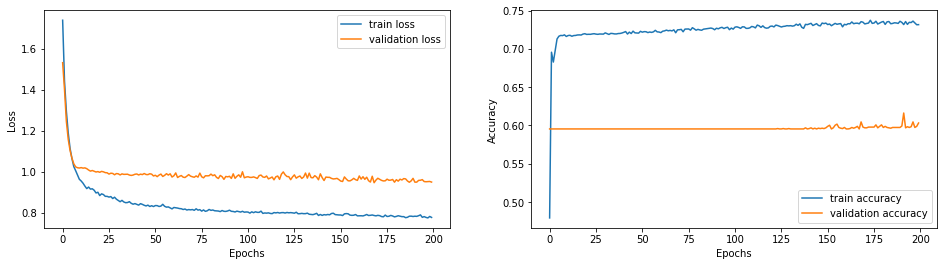

In [51]:
plot_history(history)

**Дообученные эмбединги после инициализации**

In [52]:
keras.backend.clear_session()

X_input = tf.keras.layers.Input(shape=(max_len,), name="X")
Embed_ = tf.keras.layers.Embedding(input_dim=max_words, output_dim=embed_vec_len, name="Embed_", weights=[buffer], trainable=True)(X_input)
Conv1_ = tf.keras.layers.Conv1D(filters=embed_vec_len, kernel_size=5, activation="relu", name="Conv1_")(Embed_)
GlobMaxPool1_ = tf.keras.layers.GlobalMaxPool1D(name="GlobMaxPool1")(Conv1_)
Drop1_ = tf.keras.layers.Dropout(0.6)(GlobMaxPool1_)
Dense1_ = tf.keras.layers.Dense(32, activation="relu", name="Dense1_")(Drop1_)
Drop2_ = tf.keras.layers.Dropout(0.6)(Dense1_)
Dense2_ = tf.keras.layers.Dense(32, activation="relu", name="Dense2_")(Drop2_)
Drop3_ = tf.keras.layers.Dropout(0.6)(Dense2_)
Dense3_ = tf.keras.layers.Dense(32, activation="relu", name="Dense3_")(Drop3_)
Drop4_ = tf.keras.layers.Dropout(0.6)(Dense3_)
Dense4_ = tf.keras.layers.Dense(32, activation="relu", name="Dense4_")(Drop4_)
Drop5_ = tf.keras.layers.Dropout(0.75)(Dense4_)
y_output = tf.keras.layers.Dense(num_classes, activation="softmax", name="y")(Drop5_)

model = tf.keras.models.Model(inputs=[X_input], outputs=[y_output], name="my_model")
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [53]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    )

Epoch 1/200
37/37 [==============================] - 0s 13ms/step - loss: 1.5584 - accuracy: 0.4626 - val_loss: 1.4477 - val_accuracy: 0.5954
Epoch 2/200
37/37 [==============================] - 0s 9ms/step - loss: 1.2693 - accuracy: 0.6479 - val_loss: 1.2784 - val_accuracy: 0.5954
Epoch 3/200
37/37 [==============================] - 0s 9ms/step - loss: 1.1362 - accuracy: 0.7013 - val_loss: 1.2026 - val_accuracy: 0.5954
Epoch 4/200
37/37 [==============================] - 0s 8ms/step - loss: 1.0794 - accuracy: 0.7118 - val_loss: 1.1775 - val_accuracy: 0.5954
Epoch 5/200
37/37 [==============================] - 0s 9ms/step - loss: 1.0283 - accuracy: 0.7161 - val_loss: 1.1537 - val_accuracy: 0.5954
Epoch 6/200
37/37 [==============================] - 0s 8ms/step - loss: 0.9814 - accuracy: 0.7168 - val_loss: 1.1069 - val_accuracy: 0.5954
Epoch 7/200
37/37 [==============================] - 0s 8ms/step - loss: 0.9594 - accuracy: 0.7167 - val_loss: 1.0791 - val_accuracy: 0.5954
Epoch 8/200


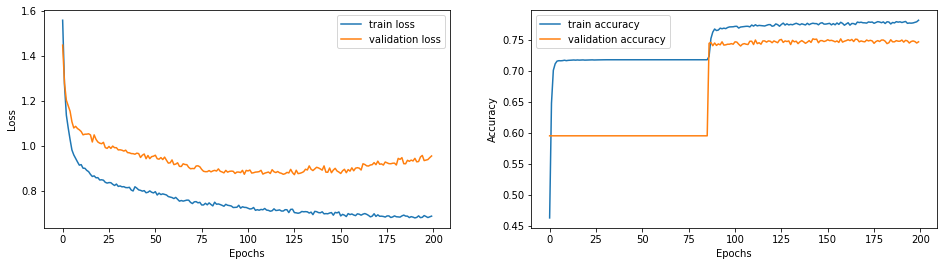

In [54]:
plot_history(history)

**Вывод:** результат практически одинаковый при инициализации Word2Vec значениями и дообучении эмбеддингов, и без инициализации. Однако при инициализации Word2Vec расхождение между train и valid существенно меньше.